In [1]:
import pyodbc
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


# Read data

In [2]:
cnxn = pyodbc.connect("DSN=Dremio Connector", 
                      autocommit=True, uid='mark.t.aloi@ey.com', pwd='P@ssword1',
                      host = '52.184.245.131', port =31010)

In [3]:
cusor = cnxn.cursor()

In [4]:
sql = '''
    select * from General."Report Sources"."Return to Work"."Covid 19 Update"
'''

In [5]:
cusor.execute(sql)

In [6]:
response = cusor.fetchall()

In [7]:
data = pd.DataFrame.from_records(response, 
                                 columns=['state_fips', 'state_name', 
                                          'county_name', 'area_name', 'lat', 
                                          'long', 'date', 'cases', 'deaths',
                                         'county_fips','id2','population_estimate_2018'])

In [8]:
data.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018
0,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-17,5,0,9005,9005,181111
1,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-18,5,0,9005,9005,181111
2,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-19,7,0,9005,9005,181111
3,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-20,8,0,9005,9005,181111
4,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-21,11,0,9005,9005,181111


In [9]:
# Remove leading and trailing white spaces
data.replace('^\s+', '', regex=True, inplace=True)
data.replace('\s+$', '', regex=True, inplace=True)

In [87]:
data['cases'] = data['cases'].astype(int)
data['population_estimate_2018'] = data['population_estimate_2018'].astype(int)
data['date'] = pd.to_datetime(data['date'])

# County name is not unique - create State-County name

In [11]:
data['state_county'] = data['state_name'] + ', ' + data['county_name']

In [12]:
data['county_name'].unique()

array(['Litchfield County', 'Middlesex County', 'New Haven County', ...,
       'Villalba Municipio', 'Yabucoa Municipio', 'Yauco Municipio'],
      dtype=object)

In [13]:
data['state_county'].nunique(), data['county_name'].nunique()

(3180, 1933)

In [14]:
print(data['cases'].isna().sum(), data['date'].isna().sum())

0 0


# Increase in Cases in the last 14 days for each county in ohio

In [79]:
last_14_day_increase = data.groupby('state_county').apply(
    lambda x: x['cases'][-1:].values[0] - x['cases'][-14:].values[0]).reset_index()
last_14_day_increase.columns = ['state_county', 'last_14_day_increase']

In [80]:
prev = len(data)
data = data.merge(last_14_day_increase, how='left')
assert(prev == len(data))

In [ ]:
data['last_14_day_inc_per_hund_thou'] = data['last_14_day_increase']/data['population_estimate_2018']*100000

# Consecutive days of positive growth

In [91]:
data['daily_increase'] = (data['cases'] - data['cases'].shift(1))
data['daily_growth'] = (data['daily_increase'] - data['daily_increase'].shift(1))

In [97]:
last_7_consecutive_growth = data.groupby('state_county').apply(
    lambda x: x['cons'][-7:].sum()).reset_index()
last_7_consecutive_growth.columns = ['state_county', 'cons_days_growth_in_last_7_days']

In [99]:
prev = len(data)
data = data.merge(last_7_consecutive_growth, how='left')
assert(prev == len(data))
data.drop('cons', axis=1, inplace=True)

## Use recent 10 cases to calculate percentage change in cases

In [15]:
# lambda x: x[-10:].pct_change().mean()*100)
pct_change = data.groupby('state_county').apply(
    lambda x: x['cases'][-10:].pct_change().mean()*100).reset_index()
pct_change.columns = ['state_county', 'change_trend']

In [16]:
pct_change.head()

,state_county,change_trend
0,"Alabama, Autauga County",2.003705
1,"Alabama, Baldwin County",5.859864
2,"Alabama, Barbour County",2.077094
3,"Alabama, Bibb County",2.857607
4,"Alabama, Blount County",4.631798


# Define growth

In [17]:
def growth(x):
    if x > 0.5 and x <=4:
        return "growth"
    elif x >4 and x<7:
        return "high growth"
    elif x>=7:
        return "very high growth"
    elif x>=-0.5 and x<=0.5:
        return "leveling off"
    else:
        return "cases decreasing"

In [75]:
data[data['state_name'] == 'Ohio']

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,last_14_day_increase
233165,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-04,1,0,39001,39001,27724,"Ohio, Adams County",3.282404,growth,3.606983,144.279325,relatively very low cases,14
233166,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-05,2,0,39001,39001,27724,"Ohio, Adams County",3.282404,growth,7.213966,144.279325,relatively very low cases,14
233167,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-06,2,0,39001,39001,27724,"Ohio, Adams County",3.282404,growth,7.213966,144.279325,relatively very low cases,14
233168,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-07,2,0,39001,39001,27724,"Ohio, Adams County",3.282404,growth,7.213966,144.279325,relatively very low cases,14
233169,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-08,2,0,39001,39001,27724,"Ohio, Adams County",3.282404,growth,7.213966,144.279325,relatively very low cases,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244006,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-21,73,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,332.801459,417.141555,relatively low cases,29
244007,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-22,74,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,337.360383,417.141555,relatively low cases,29
244008,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-23,84,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,382.949624,417.141555,relatively low cases,29
244009,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-24,91,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,414.862093,417.141555,relatively low cases,29


In [18]:
pct_change['trend'] = pct_change['change_trend'].apply(growth)

In [19]:
pct_change.trend.value_counts()

growth              2111
high growth          486
leveling off         347
very high growth     224
cases decreasing      12
Name: trend, dtype: int64

In [77]:
data[(data['state_name'] == 'Ohio') & (data['county_name'] == 'Wyandot County')].tail(14)

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,last_14_day_increase
243997,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-12,63,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,287.212218,417.141555,relatively low cases,29
243998,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-13,66,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,300.888990,417.141555,relatively low cases,29
243999,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-14,66,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,300.888990,417.141555,relatively low cases,29
244000,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-15,68,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,310.006838,417.141555,relatively low cases,29
244001,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-16,70,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,319.124687,417.141555,relatively low cases,29
244002,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-17,72,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,328.242535,417.141555,relatively low cases,29
244003,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-18,72,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,328.242535,417.141555,relatively low cases,29
244004,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-19,72,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,328.242535,417.141555,relatively low cases,29
244005,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-20,72,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,328.242535,417.141555,relatively low cases,29
244006,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-21,73,5,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,332.801459,417.141555,relatively low cases,29


In [20]:
prev = len(data)
data = data.merge(pct_change, how='left')
assert(prev == len(data))

In [21]:
data.tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend
365821,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-21,149,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth
365822,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-22,151,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth
365823,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-23,156,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth
365824,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-24,167,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth
365825,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-25,175,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth


# Calculate current cases per hundred thousand population

In [22]:
# number of cases per hundred thousand population
data['cases_per_hud_thousand'] = data['cases']/data['population_estimate_2018'] *100000

In [23]:
data.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand
0,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-17,5,0,9005,9005,181111,"Connecticut, Litchfield County",15.076232,very high growth,2.760738
1,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-18,5,0,9005,9005,181111,"Connecticut, Litchfield County",15.076232,very high growth,2.760738
2,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-19,7,0,9005,9005,181111,"Connecticut, Litchfield County",15.076232,very high growth,3.865033
3,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-20,8,0,9005,9005,181111,"Connecticut, Litchfield County",15.076232,very high growth,4.417181
4,09,Connecticut,Litchfield County,,41.7918833,-73.2354042,2020-03-21,11,0,9005,9005,181111,"Connecticut, Litchfield County",15.076232,very high growth,6.073623


In [24]:
# taking the mean of last two cases to calculate current cases per hundred thousand population
cases_thou = data.groupby('state_county').apply(
    lambda x: x['cases_per_hud_thousand'][-2:].mean()).reset_index()

In [25]:
cases_thou.columns = ['state_county', 'current_cases_per_hund_thou']

In [26]:
quartiles = cases_thou['current_cases_per_hund_thou'].quantile([0.25, 0.75], interpolation='nearest')
q1 = list(quartiles)[0]
q2 = list(quartiles)[1]
med = cases_thou['current_cases_per_hund_thou'].median()

In [27]:
# defining high and low cases based on the quartiles
def cases_thousands(x):
    if x > q2:
        return 'very high cases'
    elif x>med and x<q2:
        return 'high cases'
    elif x<med and x>q1:
        return 'relatively low cases'
    else:
        return 'relatively very low cases'

In [28]:
cases_thou['current_number_cases_category'] = cases_thou['current_cases_per_hund_thou'].apply(cases_thousands)

In [29]:
cases_thou.head()

,state_county,current_cases_per_hund_thou,current_number_cases_category
0,"Alabama, Autauga County",1666.336936,very high cases
1,"Alabama, Baldwin County",1186.806836,very high cases
2,"Alabama, Barbour County",2192.435995,very high cases
3,"Alabama, Bibb County",1386.160714,very high cases
4,"Alabama, Blount County",1082.295989,high cases


In [30]:
cases_thou.current_number_cases_category.value_counts()

relatively very low cases    797
very high cases              795
high cases                   794
relatively low cases         794
Name: current_number_cases_category, dtype: int64

In [31]:
cases_thou[cases_thou.current_number_cases_category=='relatively very low cases'].head()

,state_county,current_cases_per_hund_thou,current_number_cases_category
67,"Alaska, Aleutians East Borough",85.348506,relatively very low cases
70,"Alaska, Bethel Census Area",109.793588,relatively very low cases
72,"Alaska, Denali Borough",145.701797,relatively very low cases
79,"Alaska, Kodiak Island Borough",104.908205,relatively very low cases
80,"Alaska, Kusilvak Census Area",36.131519,relatively very low cases


In [32]:
prev = len(data)
data = data.merge(cases_thou, how='left')
assert(prev == len(data))

In [33]:
data.tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category
365821,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-21,149,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth,440.047253,505.020673,relatively low cases
365822,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-22,151,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth,445.953928,505.020673,relatively low cases
365823,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-23,156,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth,460.720614,505.020673,relatively low cases
365824,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-24,167,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth,493.207324,505.020673,relatively low cases
365825,72,Puerto Rico,Yauco Municipio,,18.0856688,-66.8579009,2020-07-25,175,0,72153,72153,33860,"Puerto Rico, Yauco Municipio",3.638325,growth,516.834022,505.020673,relatively low cases


# Ohio counties

In [34]:
ohio_counties = list(data[data['state_name'] == 'Ohio']['state_county'].unique())

# Check time series with one county

In [35]:
ts = data[data['state_county']==ohio_counties[0]].copy()

In [36]:
county_name =  ohio_counties[9]
ts = data[data['state_county']==county_name].copy()
ts = ts[['date', 'cases']].copy()
ts.date = pd.to_datetime(ts.date)
#ts = ts.set_index(['date'])
ts.cases = ts.cases.astype(int)

In [37]:
ohio_counties[9]

'Ohio, Highland County'

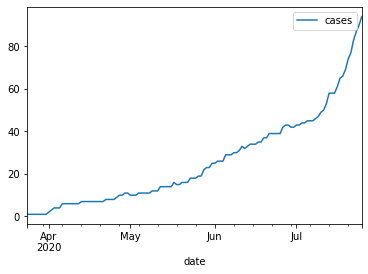

In [38]:
ts_check = ts.set_index('date')
ts_check.plot()

In [39]:
ts.tail()

,date,cases
234229,2020-07-21,77
234230,2020-07-22,83
234231,2020-07-23,87
234232,2020-07-24,90
234233,2020-07-25,94


# Prophet model

In [40]:
# Create prophet model for each county and use date only after '2020-06-01'
df = pd.DataFrame()
for ii in ohio_counties:
    ts = data[data['state_county']==ii].copy()
    # EY second wave model
    ts = ts[ts.date >=pd.to_datetime('2020-06-01')].copy()
    # Date beyond which we start the forecast
    end_date = ts['date'][-1:].values[0]
    # replicate last 10 rows
    replicated_last_10 = pd.concat([ts[-1:]]*10)
    int_df = pd.concat([ts, replicated_last_10])
    # check the baseline of last value moving forward
    ts = ts[['date', 'cases']].copy()
    ts.date = pd.to_datetime(ts.date)
    ts.columns = ['ds', 'y']
    model = Prophet()  # can also specify seasonality mode multplicative in the model
    model.fit(ts)
    future = model.make_future_dataframe(periods=10,freq = 'D')
    forecast = model.predict(future)
    fcast = forecast[['ds', 'yhat']].copy()
    fcast.columns = ['date','predicted_cases']
    int_df['date'] = list(fcast.date)
    int_df['predicted_cases'] = list(fcast.predicted_cases)
    int_df['end_cases_date'] = end_date
    df = pd.concat([df,int_df])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [41]:
len(int_df)

65

In [42]:
int_df.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,predicted_cases,end_cases_date
243956,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-01,42,2,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,191.474812,417.141555,relatively low cases,43.522564,2020-07-25
243957,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-02,45,2,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,205.151584,417.141555,relatively low cases,43.975903,2020-07-25
243958,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-03,44,2,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,200.592660,417.141555,relatively low cases,44.178873,2020-07-25
243959,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-04,48,2,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,218.828357,417.141555,relatively low cases,46.131850,2020-07-25
243960,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-05,48,2,39175,39175,21935,"Ohio, Wyandot County",3.173516,growth,218.828357,417.141555,relatively low cases,47.802877,2020-07-25


# Individually check all cases

In [43]:
number_ = 5

In [44]:
check = df[df['state_county'] == 'West Virginia, Boone County'][['date', 'cases', 'predicted_cases']]

In [45]:
check = df[df['state_county'] == ohio_counties[number_]][['date', 'cases', 'predicted_cases']]

In [46]:
ohio_counties[number_]

'Ohio, Auglaize County'

In [47]:
len(check)

65

In [48]:
check.tail(10)

,date,cases,predicted_cases
237465,2020-07-26,165,162.116561
237465,2020-07-27,165,166.717237
237465,2020-07-28,165,170.852241
237465,2020-07-29,165,174.920214
237465,2020-07-30,165,179.113186
237465,2020-07-31,165,184.556031
237465,2020-08-01,165,188.998875
237465,2020-08-02,165,192.203987
237465,2020-08-03,165,196.804663
237465,2020-08-04,165,200.939667


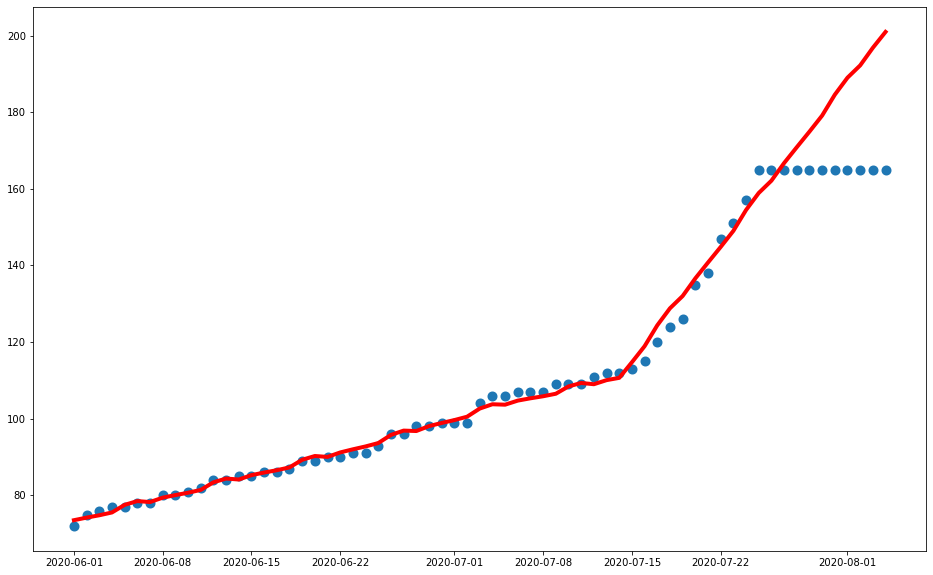

In [49]:
plt.figure (figsize=(16,10))
plt.scatter(check['date'], check['cases'], lw=4)
plt.plot(check['date'], check['predicted_cases'], color='r', lw=4)

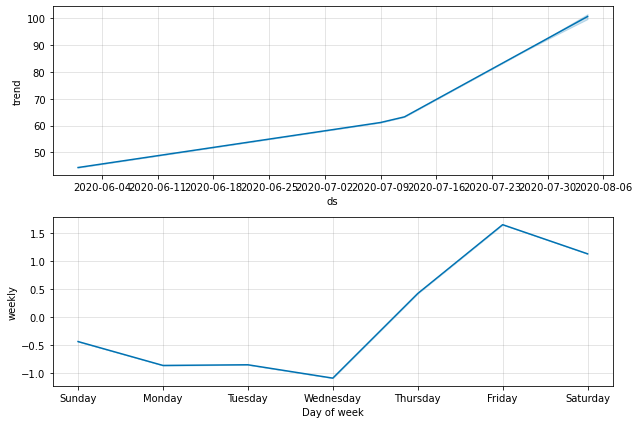

In [50]:
fig = model.plot_components(forecast)

In [51]:
df[df['state_county'] == ohio_counties[number_]].head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,predicted_cases,end_cases_date
237411,39,Ohio,Auglaize County,,40.561309,-84.2240177,2020-06-01,72,3,39011,39011,45804,"Ohio, Auglaize County",4.107891,high growth,157.191512,351.497686,relatively low cases,73.536184,2020-07-25
237412,39,Ohio,Auglaize County,,40.561309,-84.2240177,2020-06-02,75,3,39011,39011,45804,"Ohio, Auglaize County",4.107891,high growth,163.741158,351.497686,relatively low cases,74.212796,2020-07-25
237413,39,Ohio,Auglaize County,,40.561309,-84.2240177,2020-06-03,76,3,39011,39011,45804,"Ohio, Auglaize County",4.107891,high growth,165.924373,351.497686,relatively low cases,74.822375,2020-07-25
237414,39,Ohio,Auglaize County,,40.561309,-84.2240177,2020-06-04,77,3,39011,39011,45804,"Ohio, Auglaize County",4.107891,high growth,168.107589,351.497686,relatively low cases,75.556955,2020-07-25
237415,39,Ohio,Auglaize County,,40.561309,-84.2240177,2020-06-05,77,3,39011,39011,45804,"Ohio, Auglaize County",4.107891,high growth,168.107589,351.497686,relatively low cases,77.541406,2020-07-25


In [52]:
df.to_csv('predictions.csv')